# Redes Neuronales Convolucionales 
![alt text](https://cdn-images-1.medium.com/max/1600/1*NQQiyYqJJj4PSYAeWvxutg.png)
 
 

In [0]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
import itertools

% matplotlib inline

In [0]:

# habilitar eager execution
tf.enable_eager_execution()

## Importar Datos
Dataset MNIST de digitos

In [0]:
class DataLoader():
    """Load data MNIST """
    def __init__(self):
      
        # Download data
        (self.X_train, self.y_train),(self.X_test,self.y_test)= tf.keras.datasets.mnist.load_data()
        
        # Preprocessing
        self.X_train = self.X_train.reshape(-1, 28, 28, 1).astype(np.float32)/255.0 # Debe ser de la forma [batch, H, W, num_canales]
        self.X_test  = self.X_test.reshape(-1, 28, 28, 1).astype(np.float32)/255.0
        self.y_train=self.y_train.astype(np.int32) 
        self.y_test=self.y_test.astype(np.int32)
        
    def get_batch(self,batch_size):
        # Muestreo aleatorio de los datos de la forma [0, stop, size]
        index=np.random.randint(0, self.X_train.shape[0], batch_size)
        return self.X_train[index,:], self.y_train[index]

In [4]:
data_loader=DataLoader()


11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

## Modelo de Red Neuronal Convolucional

In [0]:
class CNN(tf.keras.Model):
  """ Simple Convolutional Neural Network"""
  
  # Definir la estructura
  def __init__(self):
    super().__init__()
    
    # Arquitectura del modelo
    # Convolucion 1
    self.conv1=tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=[5,5],
              padding='same',
              activation=tf.nn.relu)
    
    # Maxpooling
    self.pool1=tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2)
    
    # Convolucion 2
    self.conv2=tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=[5,5],
        padding='same',
        activation=tf.nn.relu)
    
    # MaxPooling
    self.pool2=tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2)
    
    # Flatten vector
    self.flatten=tf.keras.layers.Flatten()
    
    # Fully Connected Neural Network
    self.dense1=tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(units=10)
    
  def call(self, inputs):
    # inputs debe de ser de la forma [bs, H, W, num_channels]
    x=self.conv1(inputs) # [batch_size, 28,28, 32]
    x=self.pool1(x)   # [bs,14, 14, 32]
    x=self.conv2(x)   # [bs,14, 14, 64]
    x=self.pool2(x)   # [bs, 7,  7, 64]
    # Feature Vector
    x=self.flatten(x) # [bs, 7*7*64]
    # Fully Connected Neural Network
    x=self.dense1(x)  # [bs, 1024]
    x=self.dense2(x)  # [bs, 10 ]
    return x

  def predict(self,inputs):
    y_pred=self(inputs)
    return tf.argmax(y_pred, axis=-1)

  def evaluate(self, X_test, y_test):
    y_pred= self.predict(X_test).numpy()
    total_test_samples=y_test.shape[0]
    print("Validation Accuracy: %f " % (sum(y_pred==data_loader.y_test)/total_test_samples))

In [0]:
modelo=CNN()

In [0]:
# Hyperparametros
epochs=1000
batch_size=64
learning_rate=0.001


In [0]:
# Adam Optimizer
optimizer=tf.train.AdamOptimizer(learning_rate)

### Entrenar nuestro modelo 

In [16]:
for epoch in range(epochs):
  # Datos de entrenamientp
  X,y=data_loader.get_batch(batch_size)
  
  with tf.GradientTape() as tape:
    # forward prop
    y_pred=modelo(tf.convert_to_tensor(X))
    
    # loss function
    loss= tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_pred)
    if epoch%100==0:
      print(f'epoch: {epoch}, loss: {loss.numpy()}')
   
  # Backprop 
  grads= tape.gradient(loss, modelo.variables)
  
  # update rule (dW1, W1)
  optimizer.apply_gradients(grads_and_vars=zip(grads,modelo.variables))
  

epoch: 0, loss: 2.331900119781494
epoch: 100, loss: 0.10993383824825287
epoch: 200, loss: 0.11217467486858368
epoch: 300, loss: 0.02523372694849968
epoch: 400, loss: 0.037473782896995544
epoch: 500, loss: 0.07544918358325958
epoch: 600, loss: 0.02657720074057579
epoch: 700, loss: 0.01928395964205265
epoch: 800, loss: 0.1736569106578827
epoch: 900, loss: 0.062235888093709946


### Evaluacion 

In [17]:
modelo.evaluate(data_loader.X_test, data_loader.y_test)

Validation Accuracy: 0.985600 


### Confusion matrix

In [0]:
# Inferencia
y_pred= modelo.predict(data_loader.X_test).numpy() 

# Confusion Matrix
confMatrix=tf.confusion_matrix(data_loader.y_test, y_pred).numpy()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label\n accuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()

Confusion matrix, without normalization


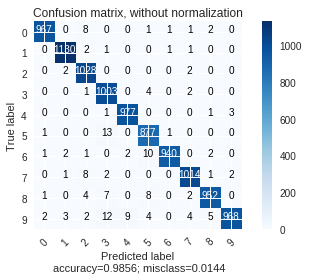

In [21]:
np.set_printoptions(precision=2)
class_names= np.array([0,1,2,3,4,5,6,7,8,9])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMatrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix


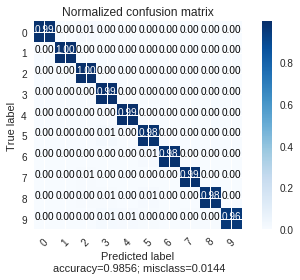

In [22]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMatrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()